## 1. Load libraries
This loads the required R packages for:
- **CellTrek** (mapping scRNA → spatial)
- **Seurat** (single-cell integration)
- **CellChat** (cell–cell communication, though not used later in this script)
- Visualization (`ggplot2`, `pheatmap`, `patchwork`, etc.)
- Clustering/statistics (`ConsensusClusterPlus`, `RColorBrewer`).

Need to install this too in env beforehand
#mamba install -c conda-forge -c bioconda bioconductor-singlecellexperiment


In [1]:
#remove.packages(c("Seurat","SeuratObject","Matrix"))
#install.packages("remotes")
#remotes::install_version("Matrix", version = "1.6.3")   
#remotes::install_version("SeuratObject", version = "4.1.3", dependencies = FALSE)
#remotes::install_version("Seurat", version = "4.3.0") #BUT MAKE SURE YOU SELECT NONE WHEN IT ASK WHICH PACKAGES TP UPDATE/UPGRADE

library(CellTrek)
library(dplyr)
library(Seurat)
#library(SeuratDisk)
library(viridis)
library(ConsensusClusterPlus)
library(RColorBrewer)
library(ggplot2)
library(ggpubr)
library(pheatmap)
library(CellChat)
library(patchwork)
library(sceasy)
library(future)
library(future.apply)

packageVersion("SeuratObject")  # 4.1.3
packageVersion("Seurat")        # 4.3.0
packageVersion("Matrix")  # 1.6.3

Warning message:
“replacing previous import ‘data.table::first’ by ‘dplyr::first’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘MASS::select’ by ‘dplyr::select’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘data.table::last’ by ‘dplyr::last’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘data.table::between’ by ‘dplyr::between’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘dplyr::as_data_frame’ by ‘igraph::as_data_frame’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘dplyr::groups’ by ‘igraph::groups’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘dplyr::union’ by ‘igraph::union’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘igraph::groups’ by ‘plotly::groups’ when loading ‘CellTrek’”
Warning message:
“replacing previous import ‘magrittr::set_names’ by ‘purrr::set_names’ when loading ‘CellTrek’”
Warning message:
“replacing 

[1] ‘4.1.3’

[1] ‘4.3.0’

[1] ‘1.6.3’

In [ ]:
#to clear up session at any point
list=ls()
list
rm(list); gc()
#gc()
#graphics.off()
#closeAllConnections()


## 2. Load input data
Loads the **Visium spatial transcriptomics** object and the **scRNA-seq** Seurat object. In this script:
- `ovVis` = Visium data (early-gen, spot-based)
- `ovSc` = single-cell RNA-seq data (annotated with cell types).

Each of the datasets have already been filtered and subset to contain only spots/cells or genes that pass the filters. These subset versions of the datasets are loaded and used here but we use the raw counts (for the cells/spots remaining) for the workflow as required by CellTrek.

In [ ]:
#cluster
cell2loc = '/mnt/scratchc/fmlab/lythgo02/OV_visium/emily/cell2location/'


ovVis <- readRDS(paste0(cell2loc, "mito_norm_emily.rds"))
ovSc <- readRDS(paste0(cell2loc, "upk10_sc_400_newlyAnnot.rds"))


In [ ]:

#local
cell2loc = '/run/user/1804238067/gvfs/sftp:host=clust1-sub-1,user=lythgo02/mnt/scratchc/fmlab/lythgo02/OV_visium/emily/cell2location/'
ov_visium = '/run/user/1804238067/gvfs/sftp:host=clust1-sub-1,user=lythgo02/mnt/nas-data/fmlab/group_folders/lythgo02/OV_visium/emily/cell2location/'

#### Load Visium Data
ovVis <- readRDS(paste0(ov_visium, "/mito_norm_emily.rds"))  #version of Ollie's filtered against mine
#ovVis <- readRDS("/home/lythgo02/Documents/OV_visium/final_adata_vis_clean_seurat.rds")

#### Load scRNA-seq
ovSc <- readRDS("/home/lythgo02/Documents/OV_visium/upk10_sc_400_newlyAnnot.rds")



If using my rds list the cell below is a method to convert the images slot to an actual SeuratImage

In [ ]:
ovVis <- readRDS("/home/lythgo02/Documents/OV_visium/split_by_sample/rds/seurat_list_all.rds")

if (!methods::isClass("SeuratImage")) {
  methods::setClass(
    "SeuratImage",
    slots = c(
      image         = "ANY",
      scale.factors = "list",
      coordinates   = "data.frame",
      assay         = "character",
      key           = "character"
    )
  )
}

for (smp in names(ovVis)) {
  obj      <- ovVis[[smp]]
  coords   <- obj@misc$spatial_coords[[smp]]
  img_info <- obj@misc$spatial_images[[smp]]

  # coords -> Seurat style, aligned to cells
  colnames(coords)[1:2] <- c("imagecol","imagerow")
  coords <- coords[match(colnames(obj), rownames(coords)), , drop = FALSE]
  rownames(coords) <- colnames(obj)

  # build minimal SeuratImage S4 (class defined earlier)
  simg <- methods::new("SeuratImage")
  simg@image         <- as.array(img_info$image)      # or img_info$images$hires
  simg@scale.factors <- img_info$scalef               # or img_info$scale.factors
  simg@coordinates   <- coords
  simg@assay         <- DefaultAssay(obj)
  simg@key           <- paste0(smp, "_")

  # >>> attach directly to the images slot (avoid [[<-)
  if (is.null(obj@images)) obj@images <- list()
  obj@images[[smp]] <- simg

  ovVis[[smp]] <- obj
}

# sanity
lapply(ovVis, function(o) class(o@images[[1]]))  # should print "SeuratImage"
# 1) Make sure each spatial object uses RNA as its default assay

for (i in names(ovVis)){
    obj <- ovVis[[i]]
    obj[["RNA"]] <- obj[["originalexp"]]
    DefaultAssay(obj) <- "RNA"
    obj[["originalexp"]] <- NULL
    ovVis[[i]] <- obj
}
ovVis <- lapply(ovVis, function(o) { DefaultAssay(o) <- "RNA"; o })

# 2) If you created SeuratImage manually, ensure its assay slot is "RNA"
for (smp in names(ovVis)) {
  im <- ovVis[[smp]]@images[[1]]
  if (!is.null(im)) im@assay <- "RNA"
  ovVis[[smp]]@images[[1]] <- im
}


Need to rename assays, note when converted to seurat object earlier (code in markdown cell run in r_spatial env) the "raw_counts" and "X" is stored under "originalexp" in the seurat objects 

For spatial we did:   

seurat_obj <- as.Seurat(
            adata,              # your SingleCellExperiment object
            counts = "raw_counts", # assay to use as raw counts
            data = "X" # optional: assay to use as normalized data
)
3. Extract sample per spot
sample <- colData(adata)$sample
seurat_obj@meta.data$sample <- sample

4. Extract coordinates and image info
coords <- reducedDim(adata, "spatial")
coords_list <- split(as.data.frame(coords), sample)
image_list <- metadata(adata)$spatial


5. Assign images and coordinates to Seurat in a CellTrek-compatible way
for (sample_name in names(coords_list)) {
  sp_coords <- coords_list[[sample_name]]
  img_info <- image_list[[sample_name]]

  seurat_obj@images[[sample_name]] <- list(
    image = as.array(img_info$image),
    scale.factors = img_info$scalef,
    coordinates = sp_coords
  )
}
1. Store original coordinates for reference
seurat_obj@misc$spatial_coords <- coords_list
seurat_obj@misc$spatial_images <- image_list

For single cell we did:  

seurat_obj <- as.Seurat(
       singlecell,              
       your SingleCellExperiment object#  counts = "counts", # assay to use as raw counts
       data = "log_counts" # optional: assay to use as normalized data
)


so:  

ovVis[["originalexp"]]$counts # = raw_counts 
ovVis[["originalexp"]]$data #= X

ovSc[["originalexp"]]$counts # = counts 
ovSc[["originalexp"]]$data #= log_counts

But mine lacks the imaging info stored in correct format so filtering Ollie's against mine below

The following silenced chunks are for filtering Ollie's mito_nrom.rds by subsetting to match the colnames (spot IDs) and rownames (genes) present in my rds
 - can't convert the adata to rds in the correct format so taking format from ollie's with processing from mine 
 - saved the end product of subsetting as mito_nrom_emily.rds and that is now loaded at the beginning 

In [ ]:
#ovVis <- readRDS(paste0(ov_visium, "/mito_norm_emily.rds"))
# 1) Split emily object by sample ID (assuming "orig.ident" marks samples)
# adjust 'split.by' if your sample column is named differently
#emily_list <- SplitObject(ovVis_emily, split.by = "sample")
#cells_ollie <- lapply(ovVis_ollie, colnames)

# Get barcodes from each Seurat object in em_list
#cells_emily <- lapply(emily_list, colnames)

#head(cells_emily[[1]])
#head(cells_ollie[[1]])
#need to append sample name to barcodes in Ollie spatial data 

# (Optional) make a backup first
#ovVis_ollie_orig <- ovVis_ollie



Need to append sample name to the colnames/spot barcodes (id) in Ollie's rds to match the formatting of mine

In [ ]:
#for (i in names(ovVis_ollie)){
#    obj <- ovVis_ollie[[i]]  #overwrite names
#    colnames(obj) <- paste0(i, "_", colnames(obj))
#    ovVis_ollie[[i]] <- obj #save back to list
#}
# Check one sample to confirm
#head(colnames(ovVis_ollie[["OV_1"]]))

# 2) Match sample names between ollie list and split emily
#common_samples <- intersect(names(ovVis_ollie), names(emily_list))

#common_samples


Now filter Ollie's spatial data by the list of spot id and genes present in my sample 
 - to ensure the filtering applied is consisted accross workflows worked on by me
 - spots are filtered to match exactly
 - genes are filtered to approximately match, exact numbers may differ due to naming conventions but assuming largely correct 

In [ ]:
#ovVis_ollie_filtered <- lapply(common_samples, function(i) {
#  obj <- DietSeurat(ovVis_ollie[[i]], graphs = TRUE) # remove the NN graphs ollie previously generated as they can disrupt subsetting
#  # --- cells ---
#  emily_barcodes <- colnames(emily_list[[i]])  #get list of spot ids from my rds (which has filtered out low quality spots)
#  cells_keep <- intersect(colnames(obj), emily_barcodes) #keep corresponding cells in Ollie's object 
#  obj <- subset(obj, cells = cells_keep)
#  # --- genes ---
#  emily_genes <- rownames(emily_list[[i]])  #get gene names remaining after filtering 
#  genes_keep <- intersect(rownames(obj), emily_genes)
  obj <- subset(obj, features = genes_keep)
#})

#names(ovVis_ollie_filtered) <- common_samples

#sapply(ovVis_ollie_filtered, ncol)
#sapply(emily_list, ncol)
#sapply(ovVis_ollie_filtered, nrow)
#sapply(emily_list, nrow)

#saveRDS(ovVis_ollie_filtered, paste0(ov_visium, "/mito_norm_emily.rds")


In [6]:
# Copy originalexp → RNA and set RNA as default
ovSc[["RNA"]] <- ovSc[["originalexp"]] #copy
DefaultAssay(ovSc) <- "RNA" #set to default
ovSc[["originalexp"]] <- NULL  # Remove the old assay

#not needed unless using my rds
#for (i in names(ovVis)){
#    obj <- ovVis[[i]]
#    obj[["RNA"]] <- obj[["originalexp"]]
#    DefaultAssay(obj) <- "RNA"
#    obj[["originalexp"]] <- NULL
#    ovVis[[i]] <- obj
#}



Warning message:
“Cannot add objects with duplicate keys (offending key: originalexp_), setting key to 'rna_'”


Note first had to convert the outputs from cell2location workflow to rds objects:
 - activate r environment 
   - mamba activate r_spatial
   - open R
   - 
library(zellkonverter)
adata <- readH5AD("/run/user/1804238067/gvfs/sftp:host=clust1-sub-1,user=lythgo02/mnt/scratchc/fmlab/lythgo02/OV_visium/emily/cell2location/final_adata_vis_clean.h5ad")
# Convert SCE to Seurat
seurat_obj <- as.Seurat(
  adata,              # your Spatial/singleCellExperiment object
  counts = "raw_counts", # assay to use as raw counts
  data = "X" # make sure to use X as this contains filtered data 
)
saveRDS(adata, file="/run/user/1804238067/gvfs/sftp:host=clust1-sub-1,user=lythgo02/mnt/scratchc/fmlab/lythgo02/OV_visium/emily/cell2location/final_adata_vis_clean.rds")

#same with single cell data
#write to local directory if it doesn't allow you to write to cluster (h5ad files can be tricky)

In [7]:
#check if integrated

colnames(ovSc@meta.data)

#sample names for single cell 
unique(ovSc@meta.data$orig.ident)
ovSc@active.assay 

unique(ovSc$updated_annotation)



[1] "orig.ident"                       "nCount_originalexp"              
 [3] "nFeature_originalexp"             "nCount_RNA"                      
 [5] "nFeature_RNA"                     "percentMt"                       
 [7] "nCount_SCT"                       "nFeature_SCT"                    
 [9] "SCT_snn_res.1"                    "seurat_clusters"                 
[11] "pANN_0.25_0.19_161"               "DF.classifications_0.25_0.19_161"
[13] "doublet_classification"           "CellAssign"                      
[15] "Treatment"                        "Cell_Type"                       
[17] "newAnnot"                         "newAnnot_1"                      
[19] "inferCNV_Score"                   "inferCNV_Class"                  
[21] "Final_Annotation"                 "CopyKat"                         
[23] "newAnnot_2"                       "pANN_0.25_0.05_197"              
[25] "DF.classifications_0.25_0.05_197" "pANN_0.25_0.19_227"              
[27] "DF.classifications_0.25_0.19_227" "pANN_0.25_0.06_117"              
[29] "DF.classifications_0.25_0.06_117" "pANN_0.25_0.28_314"              
[31] "DF.classifications_0.25_0.28_314" "SCT_snn_res.0.5"                 
[33] "ident"                            "updated_annotation"              
[35] "X_indices"                        "X_scvi_batch"                    
[37] "X_scvi_labels"

[1] OV_16 OV_17 OV_18 OV_19 OV_20
Levels: OV_16 OV_17 OV_18 OV_19 OV_20

[1] "RNA"

[1] Tumour 1             Macrophage           NK_cell             
 [4] Treg                 Tumour 2             Plasma Cells        
 [7] CD4                  CD8                  B naive activated   
[10] Mesenchymal          B naive resting      Monocytes           
[13] Dendritic Cells      Neutrophils          Th1                 
[16] Th17                 Endothelial          Tumour 3            
[19] Cycling Plasma Cells
19 Levels: B naive activated B naive resting CD4 CD8 ... Tumour 3

In [5]:
#spatial info stored in images slot 
lapply(ovVis, slotNames)

$OV_1
 [1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"       

$OV_2
 [1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"       

$OV_3
 [1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"       

$OV_4
 [1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"       

$OV_5
 [1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"       

$OV_6
 [1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"

## 3. Integrate scRNA-seq samples
Here multiple scRNA samples are merged and integrated using Seurat's anchor-based pipeline. This corrects for batch effects and aligns datasets into a shared space.
 - SelectIntegrationFeatures finds highly variable genes shared across all samples which are used as anchors for sample integration. 
 - Anchors are pairs of cells across datasets that are similar in expression.
 - object.list = ovSc tells Seurat which samples to integrate.
 - anchor.features = features uses the previously selected genes.

In [8]:

#already have single object with multiple samples 
# Split the Seurat object by sample and store in list of invdividual samples
ovSc.list <- SplitObject(ovSc, split.by = "orig.ident")

# Check the names
names(ovSc.list)



[1] "OV_16" "OV_17" "OV_18" "OV_19" "OV_20"

Single cell is currently previous version 3/4 of suerat object which uses slots, need to convert to version 5 which uses layers 
 - define function to convert to assay5

In [9]:
class(ovSc.list[[1]][["RNA"]])
sapply(ovSc.list, function(obj) class(obj[["RNA"]]))
#shows that each one of the RNA assays is in old Seurat v3/v4 style (slot based)
#have got code to update to v5 in emails in needed


[1] "Assay"
attr(,"package")
[1] "SeuratObject"

OV_16   OV_17   OV_18   OV_19   OV_20 
"Assay" "Assay" "Assay" "Assay" "Assay"

In [10]:

#### Iterate over samples in list to prepare for integration

# Make sure every object has HVGs before integration
ovSc.list <- lapply(ovSc.list, function(x){
  DefaultAssay(x) <- "RNA"
  # We already have 'counts' + 'data' layers from earlier conversion
  # Find HVGs on log-normalised data
  x <- NormalizeData(x)
  x <- FindVariableFeatures(
    x,                # use log-normalized values, not raw counts
    selection.method = "vst",
    nfeatures = 3000
  )
  x
})



In [11]:

# Select features and integrate
features <- SelectIntegrationFeatures(object.list = ovSc.list)

In [12]:
anchors <- FindIntegrationAnchors(object.list = ovSc.list, 
    normalization.method = "LogNormalize",
    anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14458 anchors

Filtering anchors

	Retained 12442 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14428 anchors

Filtering anchors

	Retained 11850 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15424 anchors

Filtering anchors

	Retained 12501 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6999 anchors

Filtering anchors

	Retained 3423 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6999 anchors

Filtering anchors

	Retained 3308 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6960 anchors

Filtering anchors

	Retained 3252 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15534 anchors

Filtering anchors

	Retained 

In [13]:
seuCombined <- IntegrateData(anchorset = anchors)

Merging dataset 1 into 5

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 2 into 5 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 4 into 5 1 3 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



## 4. Subset to cell types of interest
Selects specific immune/stromal/tumor cell types from the integrated scRNA data.
Not subsetting because already filtered the dataset in cell2location pipeline to exclude those we aren't interested in. 

In [14]:

#### Subset single cell rna-seq to cell types of interest
unique(seuCombined$updated_annotation)
table(seuCombined$updated_annotation)

#currently not removing any cell types
seuSub <- seuCombined %>% subset(updated_annotation %in% c('Tumour 1','Macrophage','NK_cell','Treg','Tumour 2',
                                                            'Plasma Cells','CD4','CD8','B naive activated','B naive resting','Mesenchymal', 'Monocytes',
                                                            'Dendritic Cells','Neutrophils','Th1','Th17','Endothelial','Tumour 3','Cycling Plasma Cells'))
                                                            
table(seuSub$updated_annotation)


[1] "Tumour 1"             "Macrophage"           "NK_cell"             
 [4] "Treg"                 "Tumour 2"             "Plasma Cells"        
 [7] "CD4"                  "CD8"                  "B naive activated"   
[10] "Mesenchymal"          "B naive resting"      "Monocytes"           
[13] "Dendritic Cells"      "Neutrophils"          "Th1"                 
[16] "Th17"                 "Endothelial"          "Tumour 3"            
[19] "Cycling Plasma Cells"


   B naive activated      B naive resting                  CD4 
                1200                  268                  404 
                 CD8 Cycling Plasma Cells      Dendritic Cells 
                 438                   25                  346 
         Endothelial           Macrophage          Mesenchymal 
                 140                 7977                  364 
           Monocytes          Neutrophils              NK_cell 
                 581                  256                  211 
        Plasma Cells                  Th1                 Th17 
                 432                  198                   78 
                Treg             Tumour 1             Tumour 2 
                 286                14301                 1225 
            Tumour 3 
                2644 


   B naive activated      B naive resting                  CD4 
                1200                  268                  404 
                 CD8 Cycling Plasma Cells      Dendritic Cells 
                 438                   25                  346 
         Endothelial           Macrophage          Mesenchymal 
                 140                 7977                  364 
           Monocytes          Neutrophils              NK_cell 
                 581                  256                  211 
        Plasma Cells                  Th1                 Th17 
                 432                  198                   78 
                Treg             Tumour 1             Tumour 2 
                 286                14301                 1225 
            Tumour 3 
                2644 

## 5. Co-embed Visium with scRNA and run CellTrek
Uses `CellTrek::traint()` trains a mapping model between single cell profiles and ST data 
 - project Visium spots and scRNA-seq cells into a **shared latent space**.
 - first need to handle images as the split object function (from downgraded seurat versions used here) can't handle images

In [ ]:
class(ovVis)
names(ovVis)

for (i in seq_along(ovVis)){
    name <- names(ovVis)[i]
    obj <- ovVis[[i]]
    assign(name, obj, envir=.GlobalEnv)
    
}



In [ ]:
#checking if colnames of spots are clean 
lapply(ovVis, function(x) any(duplicated(colnames(x))))

In [ ]:

# clean up names 
# make.names() ensures all cell names are valid R names (hanldes special characters)
# RenameCells() applies cleaned names to the Seurat object 
# Clean Visium spot names

#no need to apply to visium, already clean and characters are appropriate 
#ovVis <- lapply(ovVis, function(x){
#    RenameCells(x, new.names = make.names(Cells(x)))
#})

# Clean single-cell names
seuSub <- RenameCells(seuSub, new.names = make.names(Cells(seuSub)))


In [ ]:
seuSub@active.assay
seuSub@assays$RNA

CellTrek uses a random forest regressor to learn the mapping between your single cell reference data and spatial transcriptomics data 
 - traint() trains a mapping model between your single-cell reference and spatial sample
 - The object returned (ovTraintAll[[i]]) contains:
 - Model parameters
 - Fitted distances between spots and reference cells


In [ ]:
class(OV_1@images[[1]])
slotNames(OV_1@assays)

In [ ]:
#try on one sample first

ovtrain_ov1 <- CellTrek::traint(
    st_data    = OV_1,               # spatial Seurat object
        sc_data    = seuSub,                # single-cell reference
        sc_assay   = "RNA",         # exact assay name in seuSub
        cell_names = "updated_annotation"  # column with cell type labels
    )

In [ ]:

ovTraintAll <- lapply(ovVis, function(i) {
    ovTraint <- CellTrek::traint(st_data = i,
                                 sc_data = seuSub,
                                 sc_assay = "RNA",
                                 cell_names = "updated_annotation")
    return(ovTraint)
})

# Add names so they match the input list
names(ovTraintAll) <- names(ovVis)



In [ ]:
#saveRDS(ovTraintAll, paste0(ov_visium, "cellTrek/ovTrainAll_obj.rds"))

ovTraintAll <- readRDS(paste0(ov_visium, "cellTrek/ovTrainAll_obj.rds"))
#cluster
#saveRDS(ovTraintAll, paste0(cell2loc, "/cellTrek/ovTrainAll_obj.rds"))
#ovTraintAll <- readRDS(paste0(cell2loc, "cellTrek/ovTrainAll_obj.rds"))
#seuSub <- readRDS(paste0(cell2loc, "cellTrek/seuSub.rds"))

## 6. Visualize embeddings
Plots the joint embedding to show how Visium and scRNA cells mix, grouped by type or annotation.


Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis


Only 26 colors are available with 'alphabet'

Only 26 colors are available with 'alphabet2'

Only 25 colors are available with 'cols25'.

Only 32 colors are available with 'glasbey'.

Only 22 colors are available with 'kelly'.

Only 36 colors are available with 'polychrome'.

Only 24 colors are available with 'stepped'

Only 12 colors are available with 'tol'

Only 16 colors are available with 'watlington'.



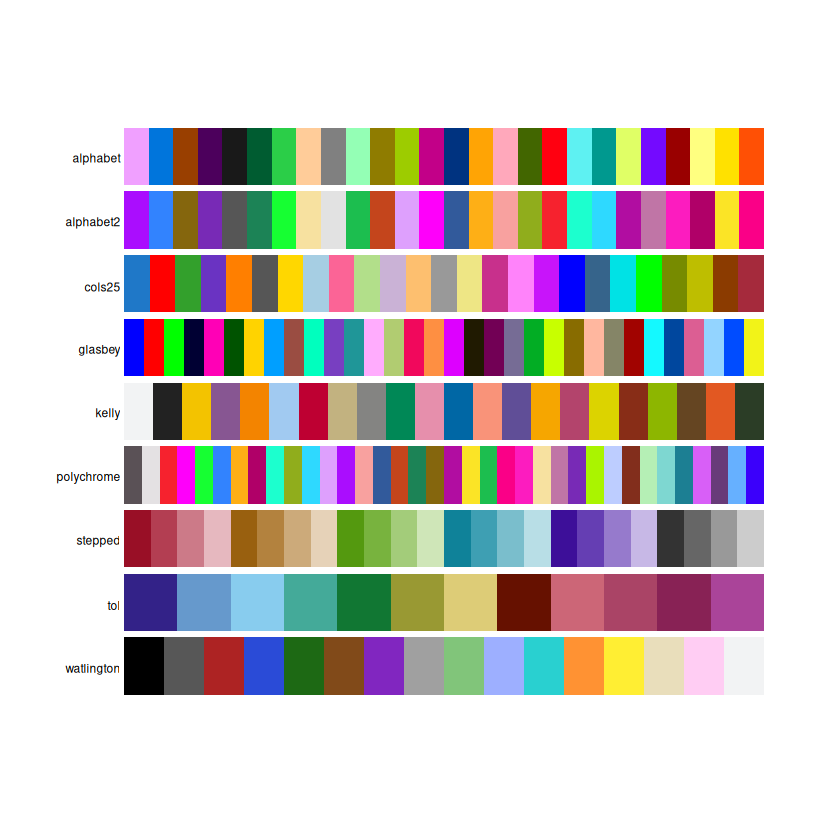

In [26]:
# ---- build a 19-colour palette----
library(pals)
pal.bands(alphabet, alphabet2, cols25, glasbey, kelly, polychrome, 
  stepped, tol, watlington,
  show.names=FALSE)

In [ ]:

#### View co-embedding
pals19 <- glasbey(19)

cols19 <- c(
  "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00",
  "#FFFF33", "#A65628", "#F781BF", "#999999", "#66C2A5",
  "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F",
  "#E5C494", "#1B9E77", "#D95F02", "#B3B3B3"
)

# Step 1: Generate plots
c2lPlots <- lapply(ovTraintAll, function(obj) {
  DimPlot(obj, group.by = "updated_annotation", cols = cols19)
})

# Step 2: Save plots
for (i in seq_along(c2lPlots)) {
  ggsave(
    filename = paste0(ov_visium, "cellTrek/DimPlot_OV", i, ".pdf"),
    plot = c2lPlots[[i]],
    width = 8,
    height = 6,
    dpi = 300
  )
}


## 7. Map cells into spatial tissue
Runs `CellTrek::celltrek()` to assign scRNA-seq cells into Visium coordinates, producing pseudo-single-cell maps. Parameters control interpolation, number of trees, PCs, distance threshold, etc.

In [ ]:
#try one sample locally

ovt1 <- [[1]]

ovCellTrek_ov1 <- 
    CellTrek::celltrek(st_sc_int = ovt1,
    int_assay = "traint",
    sc_data = sc_data,
    sc_assay = "RNA",
    reduction = "pca",
    intp = TRUE,
    intp_pnt = 1000, #reducing can speed up but impact spatial resolution and smoothness
    intp_lin = FALSE,
    nPCs = 15, 
    dist_thresh = 0.55,
    top_spot = 5,  
    spot_n = 5,  #increasing will reduce sparsity but increase time to run
    repel_r = 25,
    repel_iter = 10,
    keep_model = TRUE,
    ntree=100  #default 1000 but take a long time to run, reducing can reduce mapping accuracy 
  )
    


Run using parallelisation with 4 CPUs on the cluster (interactive session) - moved into scripts for slurm submission

sbatch celltrek.sh (which submits run_celltrek.r)

In [ ]:


# --- load libraries ---
library(CellTrek)
library(future)
library(future.apply)
library(progressr)
library(Seurat)

# --- parallelization ---
plan(multisession, workers = 6)           # use 6 cores
options(future.globals.maxSize = 20*1024^3)  # 20 GB per worker
handlers("txtprogressbar")  # to monitor progress

# --- logging set up ---
log_file <- "celltrek_progress"
sink(log_file, append=TRUE, split=TRUE)  #redirects console output to log file, split=TRUE keeps output visible in console while also writing to log 

# --- load your data ---
cell2loc = '/mnt/scratchc/fmlab/lythgo02/OV_visium/emily/cell2location/'

ovTraintAll <- readRDS(paste0(cell2loc, "cellTrek/ovTrainAll_obj.rds"))

seuSub <- readRDS(paste0(cell2loc, "cellTrek/seuSub.rds"))

# --- define celltrek wrapper ---
run_celltrek_fast <- function(trained_obj, sc_data, sample_name) {
  message(Sys.time(), "Processing ", sample_name) #adds timestamp to each log entry 
  
  ct_result <- CellTrek::celltrek(
    st_sc_int = trained_obj,
    int_assay = "traint",
    sc_data = sc_data,
    sc_assay = "RNA",
    reduction = "pca",
    intp = TRUE,
    intp_pnt = 1000,
    intp_lin = FALSE,
    nPCs = 15,
    dist_thresh = 0.55,
    top_spot = 5,
    spot_n = 5,
    repel_r = 25,
    repel_iter = 10,
    keep_model = TRUE,
    ntree=100
  )
  message(Sys.time(), " | Finished CellTrek for: ", sample_name)
  return(ct_result$celltrek)
}

# --- run CellTrek on all samples ---
with_progress({
  p <- progressor(along = ovTraintAll)
  
  celltrek_results <- future_lapply(
    seq_along(ovTraintAll),
    function(i) {
      sample_name <- names(ovTraintAll)[i]
      message(Sys.time(), " | Processing sample: ", sample_name)
      
      result <- run_celltrek_fast(
        trained_obj = ovTraintAll[[i]],
        sc_data = seuSub,
        sample_name = sample_name
      )
      
      saveRDS(result, file = paste0("celltrek_results", sample_name, ".rds"))
      message(Sys.time(), " | Saved result for: ", sample_name)
      
      p()  # update progress bar
      return(result)
    },
    future.stdout = TRUE
  )
})

saveRDS(celltrek_results, file = paste0("celltrek_results.rds"))

# --- merge results ---
merged_celltrek <- merge(celltrek_results[[1]], y = celltrek_results[-1])
merged_celltrek$treatment <- ifelse(
  merged_celltrek$orig.ident %in% c("ov_1","ov_2","ov_3"),
  "Untreated", "Treated"
)

# --- downstream co-embedding ---
DefaultAssay(merged_celltrek) <- "RNA"
merged_celltrek <- NormalizeData(merged_celltrek)
merged_celltrek <- FindVariableFeatures(merged_celltrek)
merged_celltrek <- ScaleData(merged_celltrek)
merged_celltrek <- RunPCA(merged_celltrek)
merged_celltrek <- RunUMAP(merged_celltrek, dims = 1:25)

# --- save results ---
saveRDS(merged_celltrek, "merged_celltrek.rds")
message("CellTrek pipeline finished successfully.")

    



View co-embeddings:
 - can first merge (which requires normalisation etc again) if you want to compare treated vs untreated in one integrated embedding
 - or keep as separate objects and plot individual (in which case don't use merged rds)

In [ ]:
cell2loc = '/run/user/1804238067/gvfs/sftp:host=clust1-sub-1,user=lythgo02/mnt/scratchc/fmlab/lythgo02/OV_visium/emily/cell2location/'
ovTraintAll <- readRDS(paste0(cell2loc, "cellTrek/ovTrainAll_obj.rds"))

In [ ]:
names(ovTraintAll)

[1] "OV_1" "OV_2" "OV_3" "OV_4" "OV_5" "OV_6"

In [ ]:
#load 

ovCellTrekList <- readRDS(paste0(cell2loc, "/cellTrek/celltrek_results.rds"))

names(ovCellTrekList) <- names(ovTraintAll)
#convert updated annotation to factor with levels organised in alphabetical order for plotting purposes 
ovCellTrekList <- lapply(ovCellTrekList, function(ovCellTrek){
    ovCellTrek$cell_type <- factor(ovCellTrek$updated_annotation,
                                   levels=sort(unique(ovCellTrek$updated_annotation)))
    return(ovCellTrek)
})



In [ ]:
Set x and y limits for plotting 
 - setting coordinates for xlim() and ylim() for ggplot to zoom/crop the plot to specific region of interest

In [ ]:
xl <- list()
xl$OV_1 <- c(15, 585)
xl$OV_2 <- c(20, 580)
xl$OV_3 <- c(20, 580)
xl$OV_4 <- c(20, 580)
xl$OV_5 <- c(20, 580)
xl$OV_6 <- c(15, 585)
xl$OV_7 <- c(15, 585)
xl$OV_8 <- c(15, 585)
xl$OV_9 <- c(25, 575)
xl$OV_10 <- c(20, 575)
xl$OV_11 <- c(25, 575)
xl$OV_12 <- c(25, 575)

names(xl) <- names(ovCellTrekList)


yl <- list()
yl$OV_1 <- c(15, 585)
yl$OV_2 <- c(15, 575)
yl$OV_3 <- c(25, 565)
yl$OV_4 <- c(25, 565)
yl$OV_5 <- c(20, 580)    
yl$OV_6 <- c(20, 570)
yl$OV_7 <- c(35, 560)
yl$OV_8 <- c(15, 585)
yl$OV_9 <- c(25, 575)
yl$OV_10 <- c(5, 575)  
yl$OV_11 <- c(25, 565)
yl$OV_12 <- c(25, 565)

names(yl) <- names(ovCellTrekList)

In [ ]:
cellTrekPlots <- lapply(names(ovCellTrekList), function(sampN){
    ovCellTrek <- ovCellTrekList[[sampN]]

    img_fact <- ovCellTrek@images$slice1@scale.factors$lowres
    img_temp <- ovCellTrek@images$slice1@image
    img_data <- ovCellTrek@meta.data %>% dplyr::select(coord_x, coord_y, cell_type:id_new)
    img_data$coord_x_new=img_data$coord_y*img_fact
    img_data$coord_y_new=dim(img_temp)[1]-img_data$coord_x*img_fact
    img_data$color_var <- factor(img_data[, "cell_type"])
    img_data$shape_var <- ''

    if (length(levels(img_data$color_var))<=9) {
        pnt_colors <- brewer.pal(length(levels(img_data$color_var)), "Set1")
    } else {
        pnt_colors <- colorRampPalette(brewer.pal(9, "Set1"))(length(levels(img_data$color_var)))
    }

    if (length(levels(img_data$color_var))<=9) {
        pnt_colors <- brewer.pal(length(levels(img_data$color_var)), "Set1")
    } else {
        pnt_colors <- colorRampPalette(brewer.pal(9, "Set1"))(length(levels(img_data$color_var)))
    }
    

    ggplot(img_data, aes(x=coord_x_new, y=coord_y_new, fill=cell_type)) +
    background_image(raster.img = img_temp)+
    geom_jitter(size = 1, shape = 21, stroke = 0.02, color = "black") +
    xlim(xl[[sampN]]) +
    ylim(yl[[sampN]])

})

names(cellTrekPlots) <- names(ovCellTrekList)

In [ ]:
cellTrekPlots

In [95]:
for (i in seq_along(cellTrekPlots)) {
  ggsave(
    filename = paste0(cell2loc, "cellTrek/celltrek_OV", i, ".pdf"),
    plot = cellTrekPlots[[i]],
    width = 8,
    height = 6,
    dpi = 300
  )
}



Spatial Colocalisation 
 - CellTrek::scoloc() analyzes how different cell types are spatially arranged relative to one another. It builds a graph-based model of spatial proximity and interaction:
 - use_method = 'DT': uses Delaunay triangulation to define spatial neighborhoods
 - boot_n = 200: performs 200 bootstrap iterations to assess statistical robustness

In [ ]:

ovSGraphKlList <- lapply(ovCellTrekList, function(ovCellTrek){
    CellTrek::scoloc(
        ovCellTrek,
        col_cell = 'updated_annotation',
        use_method = 'DT',
        boot_n = 200
    )
})


Cellchat 

In [ ]:
distMats <- lapply(cellTrekObs, function(ctOb){
    obCoord <- ctOb@meta.data[,c("coord_x", "coord_y")]
    obDist <- CellChat::computeRegionDistance(obCoord, group = ctOb$cell_type, spot)
    return(obDist)
})

ERROR: Error in CellChat::computeRegionDistance(obCoord, group = ctOb$cell_type, : unused argument (group = ctOb$cell_type)


## 8. Co-localisation analysis
Uses `CellTrek::scoloc()` to analyze spatial proximity between cell types. This builds a graph of neighboring cells, bootstraps it, and extracts consensus MST matrices. Later, differences between pre- and post-treatment are computed and visualized as heatmaps.

In [ ]:

#### Co-localisation analysis
ovSGraphKlList <- lapply(ovCellTrekList, function(ovCellTrek){
    ovSGraphKl <- CellTrek::scoloc(ovCellTrek,
                               col_cell='Final_Annotation',
                               use_method='DT',
                               boot_n=200)
})
samp1 <- ovCellTrekList[[1]]
head(samp1$coord_x)


## 9. Visualization & output
Plots cell maps overlaid on histology, generates combined figures, and saves results. Finally, writes CellTrek objects to disk for later use.

In [ ]:

#### Write results
saveRDS(ovCellTrekList, "../data/cellTrek/ov_cellTrek_obj.rds")
sessionInfo()
